# Les imports 

In [6]:
# --- Notebook : Modèle Linéaire - Cas de Tests de Régression ---
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# === Chargement de la bibliothèque Rust compilée ===
lib = ctypes.CDLL("../../../target/release/mymodel.dll")

In [8]:
# === classification binaire par descente de gradient ===
lib.create_linear_model_gradient_descent.argtypes = [ctypes.c_size_t, ctypes.c_double, ctypes.c_size_t]
lib.create_linear_model_gradient_descent.restype = ctypes.c_void_p

lib.train_linear_model_gradient_descent_with_activation.argtypes = [
    ctypes.c_void_p,                     # model_ptr
    ctypes.POINTER(ctypes.c_double),    # x_ptr
    ctypes.POINTER(ctypes.c_double),    # y_ptr
    ctypes.c_size_t,                    # n_samples
    ctypes.c_size_t,                    # n_features
    ctypes.c_uint                       # activation_id 
]

lib.predict_linear_model_gradient_descent_with_activation.argtypes = [
    ctypes.c_void_p,                    # model_ptr
    ctypes.POINTER(ctypes.c_double),   # x_ptr
    ctypes.c_size_t,                   # n_features
    ctypes.c_uint                      # activation_id 
]
lib.predict_linear_model_gradient_descent_with_activation.restype = ctypes.c_double


## Classification binaire

### Linear Simple :
        Linear Model : OK
   
        

Prédictions LinearModel (tanh) :
[1.0, 1.0] → attendu : 1, sortie : 0.742 → classe prédite : 1
[2.0, 3.0] → attendu : -1, sortie : -0.875 → classe prédite : 0
[3.0, 3.0] → attendu : -1, sortie : -0.900 → classe prédite : 0

Précision : 100.00%


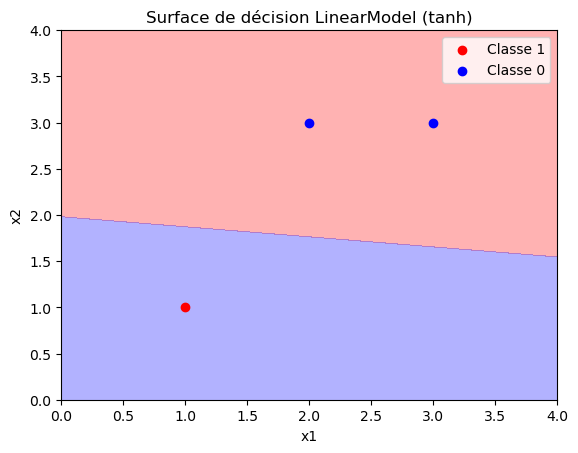

In [9]:
# === Données ===
X = np.array([
    [1, 1],
    [2, 3],
    [3, 3]
], dtype=np.float64)
Y = np.array([1, -1, -1], dtype=np.float64)

n_samples, n_features = X.shape

# === Création et entraînement du modèle ===
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.01, 1000)

lib.train_linear_model_gradient_descent_with_activation(
    model_ptr,
    X.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features,
    1  # tanh
)

# === Prédiction sur un point 
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_gradient_descent_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # tanh
    )

# === Prédictions et affichage
print("Prédictions LinearModel (tanh) :")
Y_pred = []
for xi, yi in zip(X, Y):
    out = predict(xi)
    classe = 1 if out >= 0 else 0
    Y_pred.append(out)
    print(f"{xi.tolist()} → attendu : {int(yi)}, sortie : {out:.3f} → classe prédite : {classe}")

# === Calcul de la précision
Y_true = (Y == 1).astype(np.uint32)
Y_pred_binary = (np.array(Y_pred) >= 0).astype(np.uint32)

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"\nPrécision : {accuracy * 100:.2f}%")

# === Visualisation 
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(point) for point in grid])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[0, 0], X[0, 1], color="red", label="Classe 1")
plt.scatter(X[1:, 0], X[1:, 1], color="blue", label="Classe 0")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Surface de décision LinearModel (tanh)")
plt.legend()
plt.show()


### Linear Multiple :
        Linear Model : OK
        

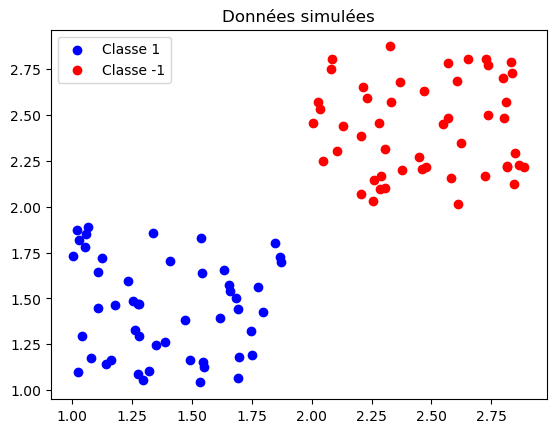

Précision : 100.00%


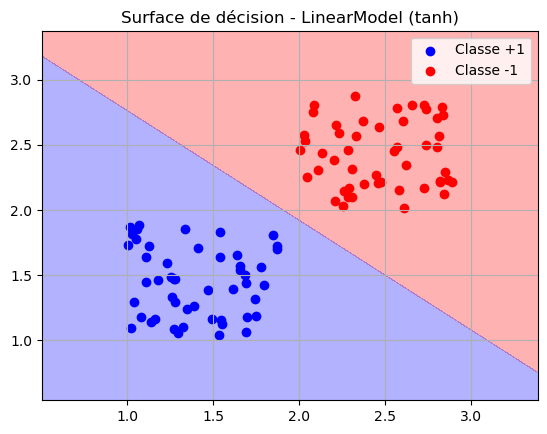

In [ ]:
# === Données : 2 clusters autour de [1,1] (classe 1) et [2,2] (classe -1)
np.random.seed(42)  # pour reproductibilité

X = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([2, 2])
])
Y = np.concatenate([
    np.ones((50, 1)),
    -1.0 * np.ones((50, 1))
]).flatten() 

# Affichage initial
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', label='Classe 1')
plt.scatter(X[50:100, 0], X[50:100, 1], color='red', label='Classe -1')
plt.title("Données simulées")
plt.legend()
plt.show()
plt.clf()
n_samples, n_features = X.shape

# === Créer le modèle Rust
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.05, 2000)

# === Entraîner
lib.train_linear_model_gradient_descent_with_activation(
    model_ptr,
    X.flatten().astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features,
    1  # tanh
)

# === Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_gradient_descent_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # tanh
    )
# Prédiction sur l’ensemble
Y_pred = np.array([predict(row) for row in X])
Y_true = (Y == 1).astype(np.uint32)
Y_pred_binary = (Y_pred >= 0).astype(np.uint32)

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"Précision : {accuracy * 100:.2f}%")

# === Visualisation de la surface de décision
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid])
Z = Z.reshape(xx.shape)

# === Visualisation
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Classe -1')
plt.title("Surface de décision - LinearModel (tanh)")
plt.legend()
plt.grid(True)
plt.show()
plt.close()


### XOR :
        Linear Model    : OK

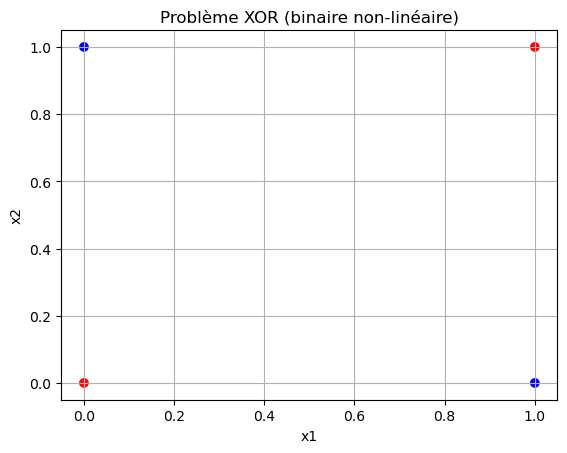

Précision (descente de gradient + tanh) : 50.00%


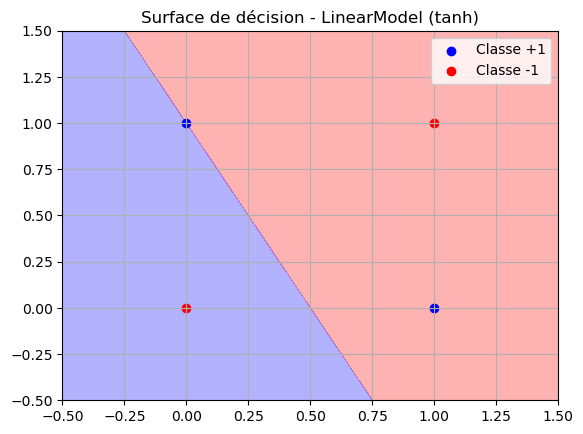

In [11]:
# === Données du problème XOR
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=np.float64)

Y = np.array([
    -1,  # 0 XOR 0 = 0 → -1
    1,   # 0 XOR 1 = 1 → +1
    1,   # 1 XOR 0 = 1 → +1
    -1   # 1 XOR 1 = 0 → -1
], dtype=np.float64)

# === Affichage des points
colors = ['red' if y == -1 else 'blue' for y in Y]
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.title("Problème XOR (binaire non-linéaire)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
plt.clf()

n_samples, n_features = X.shape
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.1, 5000)

lib.train_linear_model_gradient_descent_with_activation(
    model_ptr,
    X.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features,
    1  # tanh
)

# Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_gradient_descent_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1  # tanh
    )

# Prédictions et évaluation
Y_pred = np.array([predict(row) for row in X])
Y_true = (Y == 1).astype(np.uint32)
Y_pred_binary = (Y_pred >= 0).astype(np.uint32)

accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"Précision (descente de gradient + tanh) : {accuracy * 100:.2f}%")

# Surface de décision
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid]).reshape(xx.shape)

# === Visualisation
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Classe +1')
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color='red', label='Classe -1')
plt.title("Surface de décision - LinearModel (tanh)")
plt.legend()
plt.grid(True)
plt.show()
plt.close()

### Cross :
        Linear Model    : KO
        

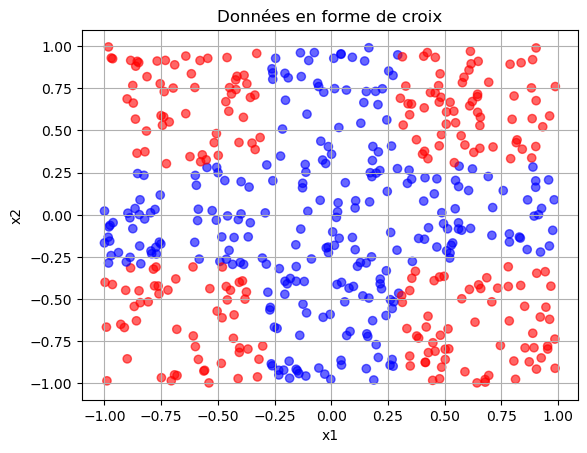

Précision (descente de gradient + tanh) : 43.80%


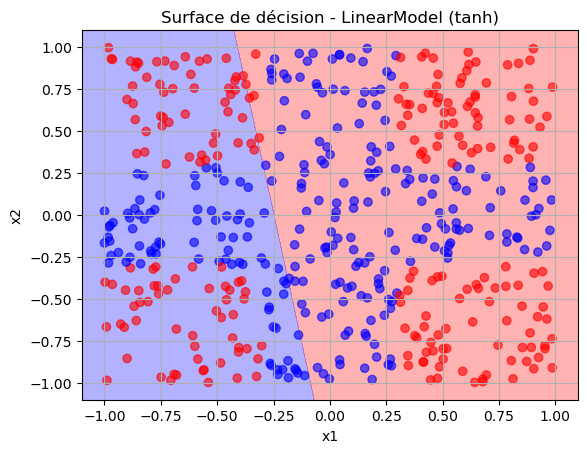

<Figure size 640x480 with 0 Axes>

In [14]:
# Génération des données
X = np.random.random((500, 2)) * 2.0 - 1.0  # Points dans [-1, 1] x [-1, 1]

# Étiquette : +1 si dans une bande horizontale ou verticale
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X], dtype=np.float64)

# Affichage
colors = ['blue' if y == 1 else 'red' for y in Y]
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6)
plt.title("Données en forme de croix")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
plt.clf()

n_samples, n_features = X.shape

# Création du modèle
model_ptr = lib.create_linear_model_gradient_descent(n_features, 0.05, 5000)

# Entraînement avec tanh
lib.train_linear_model_gradient_descent_with_activation(
    model_ptr,
    X.flatten().astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    n_samples,
    n_features,
    1  # tanh
)

# Fonction de prédiction
def predict(x):
    x_np = np.array(x, dtype=np.float64)
    return lib.predict_linear_model_gradient_descent_with_activation(
        model_ptr,
        x_np.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        len(x_np),
        1
    )

# Prédiction sur l’ensemble
Y_pred_continuous = np.array([predict(xi) for xi in X])
Y_pred_binary = (Y_pred_continuous >= 0).astype(np.uint32)
Y_true = (Y == 1).astype(np.uint32)


accuracy = (Y_true == Y_pred_binary).sum() / len(Y_true)
print(f"Précision (descente de gradient + tanh) : {accuracy * 100:.2f}%")

# Affichage de la surface de décision
x_min, x_max = -1.1, 1.1
y_min, y_max = -1.1, 1.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([predict(pt) for pt in grid]).reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["red", "blue"])
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6)
plt.title("Surface de décision - LinearModel (tanh)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
plt.clf()

